## Final Project Submission

Student name: Peninah Wambui Gituku, Lesley Wanjiku, Cynthia Adisa, Bushra Mohamed 

Student pace: Part time

Scheduled project review date/time:

Instructor name:Maryann Mwikali

# Business understanding

# Overview

Real world problem: Many homeowners are faced with the dilemma of whether or not to invest in home renovations. They want to enhance their living spaces and potentially increase the value of their homes, but they lack the knowledge and guidance to make informed decisions about which renovations are most likely to yield a positive return on investment (ROI). This problem is exacerbated by the fact that renovation projects can be costly and disruptive.

# Problem Statement
A real estate agency needs to provide advice to homeowners about how home renovations might increase the estimated values of their homes and by what amount

# Importing Libraries
Libraries are used to enhance data manipulation.

These comprises of;

NumPy which is an open source project aiming to enable numerical computing with Python.

Pandas which is also a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

Libraries for visualization;

Seaborn: It is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

Matplotlib: It is a comprehensive library for creating static, animated, and interactive visualizations in Python.

Libraries for modelling tasks;scikit-learn

Simple and efficient tools for predictive data analysis, accessible to everybody, and reusable in various contexts built on NumPy, SciPy, and matplotlib

In [1]:
# Importing the necessary libraries to be used in the analysis
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms

# Data Understanding

# Primary Data Source
The primary source of our data will be the file contained in data 'data/kc_house_data.csv'. Below, you'll find details about the dataset.

# Column Names in the dataset and their descriptions

"***id***" - Unique identifier for a house. 

"***date***" - Date house was sold.

"***price***" - Sale price (prediction target).

"***bedrooms***" - Number of bedrooms.

"***bathrooms***" - Number of bathrooms.

"***sqft_living***" - Square footage of living space in the home.

"***sqft_lot***" - Square footage of the lot.

"***floors***" - Number of floors (levels) in house.

"***waterfront***" - Whether the house is on a waterfront.

"***view***" - Quality of view from house.

"***condition***" - How good the overall condition of the house is.

"***grade***" - Overall grade of the house.

"***sqft_above***" - Square footage of house apart from basement.

"***sqft_basement***" - Square footage of the basement.

"***yr_built***" - Year when house was built.

"***yr_renovated***" - Year when house was renovated.

"***zipcode***" - ZIP Code used by the United States Postal Service.

"***lat***" - Latitude coordinate.

"***long***" - Longitude coordinate.

"***sqft_living15***" - The square footage of interior housing living space for the nearest 15 neighbors.

"***sqft_lot15***" - The square footage of the land lots of the nearest 15 neighbors.

## Data Preparation
Load the dataset to be used in the analysis

In [2]:
#Importing the data set
housing_df = pd.read_csv("data/kc_house_data.csv") 

In [3]:
# Previewing the top of our dataset
housing_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/09/2014,538000,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/09/2014,604000,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
# Previewing the bottom of our datset
housing_df.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21592,263000018,5/21/2014,360000,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0,2004,0.0,98027,47.5345,-122.069,1410,1287
21596,1523300157,10/15/2014,325000,2,0.75,1020,1076,2.0,NO,NONE,...,7 Average,1020,0,2008,0.0,98144,47.5941,-122.299,1020,1357


## Data Understanding

This involves an exploration of the dataset's properties, structure, and crucial characteristics. The key steps include investigating:

<span style="color:purple;">1. The overview of the data and its data types.</span>

# Overview
We are using the King County House Sales dataset, King County House Sales refer to the real estate market and transactions involving residential properties in King County, Washington, including the greater Seattle area. The market is dynamic, influenced by factors like the local economy, housing demand, and transportation infrastructure. Home prices can vary widely, and trends in sales and inventory levels impact pricing and competitiveness. The local economy, job opportunities, and accessibility to transportation are key drivers of the market. Market fluctuations are common, influenced by interest rates, national economic conditions, and regulations. Real estate professionals and data analysis are crucial for navigating this market. It can also be attractive for real estate investment due to its economic growth.
The data has already been loaded in the code cell below.

In [5]:
#Check the overview of the data to understand the data i.e. non-null values, data types
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  int64  
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The data types in the various columns are: float64(6), int64(9), object(6)

<span style="color:purple;">2. Shape of the data.</span>

In [6]:
# check no.or rows and columns
housing_df.shape

(21597, 21)

The dataset's shape is (21597, 21), this means that the data has 21 columns and 21597 rows.

<span style="color:purple;">3. Column names.</span>

In [7]:
# check columns names
housing_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

<span style="color:purple;">4. Summary statistics of the data.</span>

In [8]:
# statistical  summary of the data
housing_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


<span style="color:purple;">5. Existence of missing data.</span>

In [9]:
#Check for missing values
# Count of the missing values
housing_df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

From the above result we see that waterfront has 2376 missing values, view has 63 missing values, while the year the houses were renovated has 3842 missing values.

<span style="color:purple;">6. Existence of duplicate entries.</span>

In [10]:
# Checking for existence of duplicate entries
housing_df.duplicated().sum()

0

This means that there are no duplicated row  in the dataset

## Data Cleaning
Handling missing values

In [11]:
housing_df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

### Checking the percentage of missing value

In [12]:
(housing_df.isnull().mean())*100

id                0.000000
date              0.000000
price             0.000000
bedrooms          0.000000
bathrooms         0.000000
sqft_living       0.000000
sqft_lot          0.000000
floors            0.000000
waterfront       11.001528
view              0.291707
condition         0.000000
grade             0.000000
sqft_above        0.000000
sqft_basement     0.000000
yr_built          0.000000
yr_renovated     17.789508
zipcode           0.000000
lat               0.000000
long              0.000000
sqft_living15     0.000000
sqft_lot15        0.000000
dtype: float64

The "waterfront" column has approximately 11.00% missing values, indicating that a significant portion of data in this column is absent. The "yr_renovated" column has approximately 18.00% missing values, indicating that a significant portion of data in this column is also absent. Additionally, the "view" column has a smaller but still notable percentage of missing data, accounting for approximately 0.29% of its values.

In [13]:
#checking unique values in the waterfront column
housing_df['waterfront'].unique()

#checking the value counts
housing_df['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

Given that the waterfront column predominantly contains the value 'NO' with 19,075 entries, while 'YES' is significantly less frequent with only 146 entries, it is evident that the majority of houses in this dataset do not have a waterfront view. As such, it's reasonable to assume that the houses with missing values in this column also do not have a waterfront view.

In [14]:
#checking for unique values in the view column
housing_df['view'].unique()
#checking value counts
housing_df['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

Considering that the majority of properties in the dataset are categorized as 'NONE', indicating no specific view mentioned.

In [15]:
# Drop columns with missing values
housing_df = housing_df.dropna()

In [16]:
# Verify that the missing values have been handled
housing_df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Exploring and Visualising our Data

Before proceeding with any transformations, it is essential to examine the data distributions. This helps us in identifying categorical variables and continuous variables, assessed potential outliers and assessing whether certain features adhere to a normal distribution pattern.

In [17]:
housing_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,12/09/2014,538000,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400,1951,1991.0,98125,47.7210,-122.319,1690,7639
3,2487200875,12/09/2014,604000,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,05/12/2014,1230000,4,4.50,5420,101930,1.0,NO,NONE,...,11 Excellent,3890,1530,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500,3,2.25,1715,6819,2.0,NO,NONE,...,7 Average,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,2997800021,2/19/2015,475000,3,2.50,1310,1294,2.0,NO,NONE,...,8 Good,1180,130,2008,0.0,98116,47.5773,-122.409,1330,1265
21592,263000018,5/21/2014,360000,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0,2009,0.0,98144,47.5944,-122.299,1020,2007


In [18]:
#Dropping columns that will not be useful in regression
housing_df = housing_df.drop(['id','date','view', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'sqft_basement','yr_renovated', 'lat', 'long', 'zipcode', 'yr_renovated'], axis=1)
housing_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
1,538000,3,2.25,2570,7242,2.0,NO,Average,7 Average,1951
3,604000,4,3.00,1960,5000,1.0,NO,Very Good,7 Average,1965
4,510000,3,2.00,1680,8080,1.0,NO,Average,8 Good,1987
5,1230000,4,4.50,5420,101930,1.0,NO,Average,11 Excellent,2001
6,257500,3,2.25,1715,6819,2.0,NO,Average,7 Average,1995


In [19]:
housing_df['waterfront'] = housing_df['waterfront'].replace(('YES', 'NO'), (1, 0))

condition_dict = {
    'Poor': 0,
    'Fair': 1,
    'Average': 2,
    'Good': 3,
    'Very Good': 4
}
housing_df['condition'] = housing_df['condition'].map(condition_dict)

grade_dict = {
    '3 Poor': 3,
    '4 Low': 4,
    '5 Fair': 5,
    '6 Low Average': 6,
    '7 Average': 7,
    '8 Good': 8,
    '9 Better': 9,
    '10 Very Good': 10,
    '11 Excellent': 11,
    '12 Luxury': 12,
    '13 Mansion': 13
}
housing_df['grade'] = housing_df['grade'].map(grade_dict)
housing_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
1,538000,3,2.25,2570,7242,2.0,0,2,7,1951
3,604000,4,3.00,1960,5000,1.0,0,4,7,1965
4,510000,3,2.00,1680,8080,1.0,0,2,8,1987
5,1230000,4,4.50,5420,101930,1.0,0,2,11,2001
6,257500,3,2.25,1715,6819,2.0,0,2,7,1995
...,...,...,...,...,...,...,...,...,...,...
21591,475000,3,2.50,1310,1294,2.0,0,2,8,2008
21592,360000,3,2.50,1530,1131,3.0,0,2,8,2009
21593,400000,4,2.50,2310,5813,2.0,0,2,8,2014
21594,402101,2,0.75,1020,1350,2.0,0,2,7,2009


In [20]:
#checking for unique values in the view column
housing_df['grade'].unique()
#checking value counts
housing_df['grade'].value_counts()

7     6539
8     4438
9     1920
6     1482
10     832
11     290
5      167
12      66
4       16
13      11
3        1
Name: grade, dtype: int64

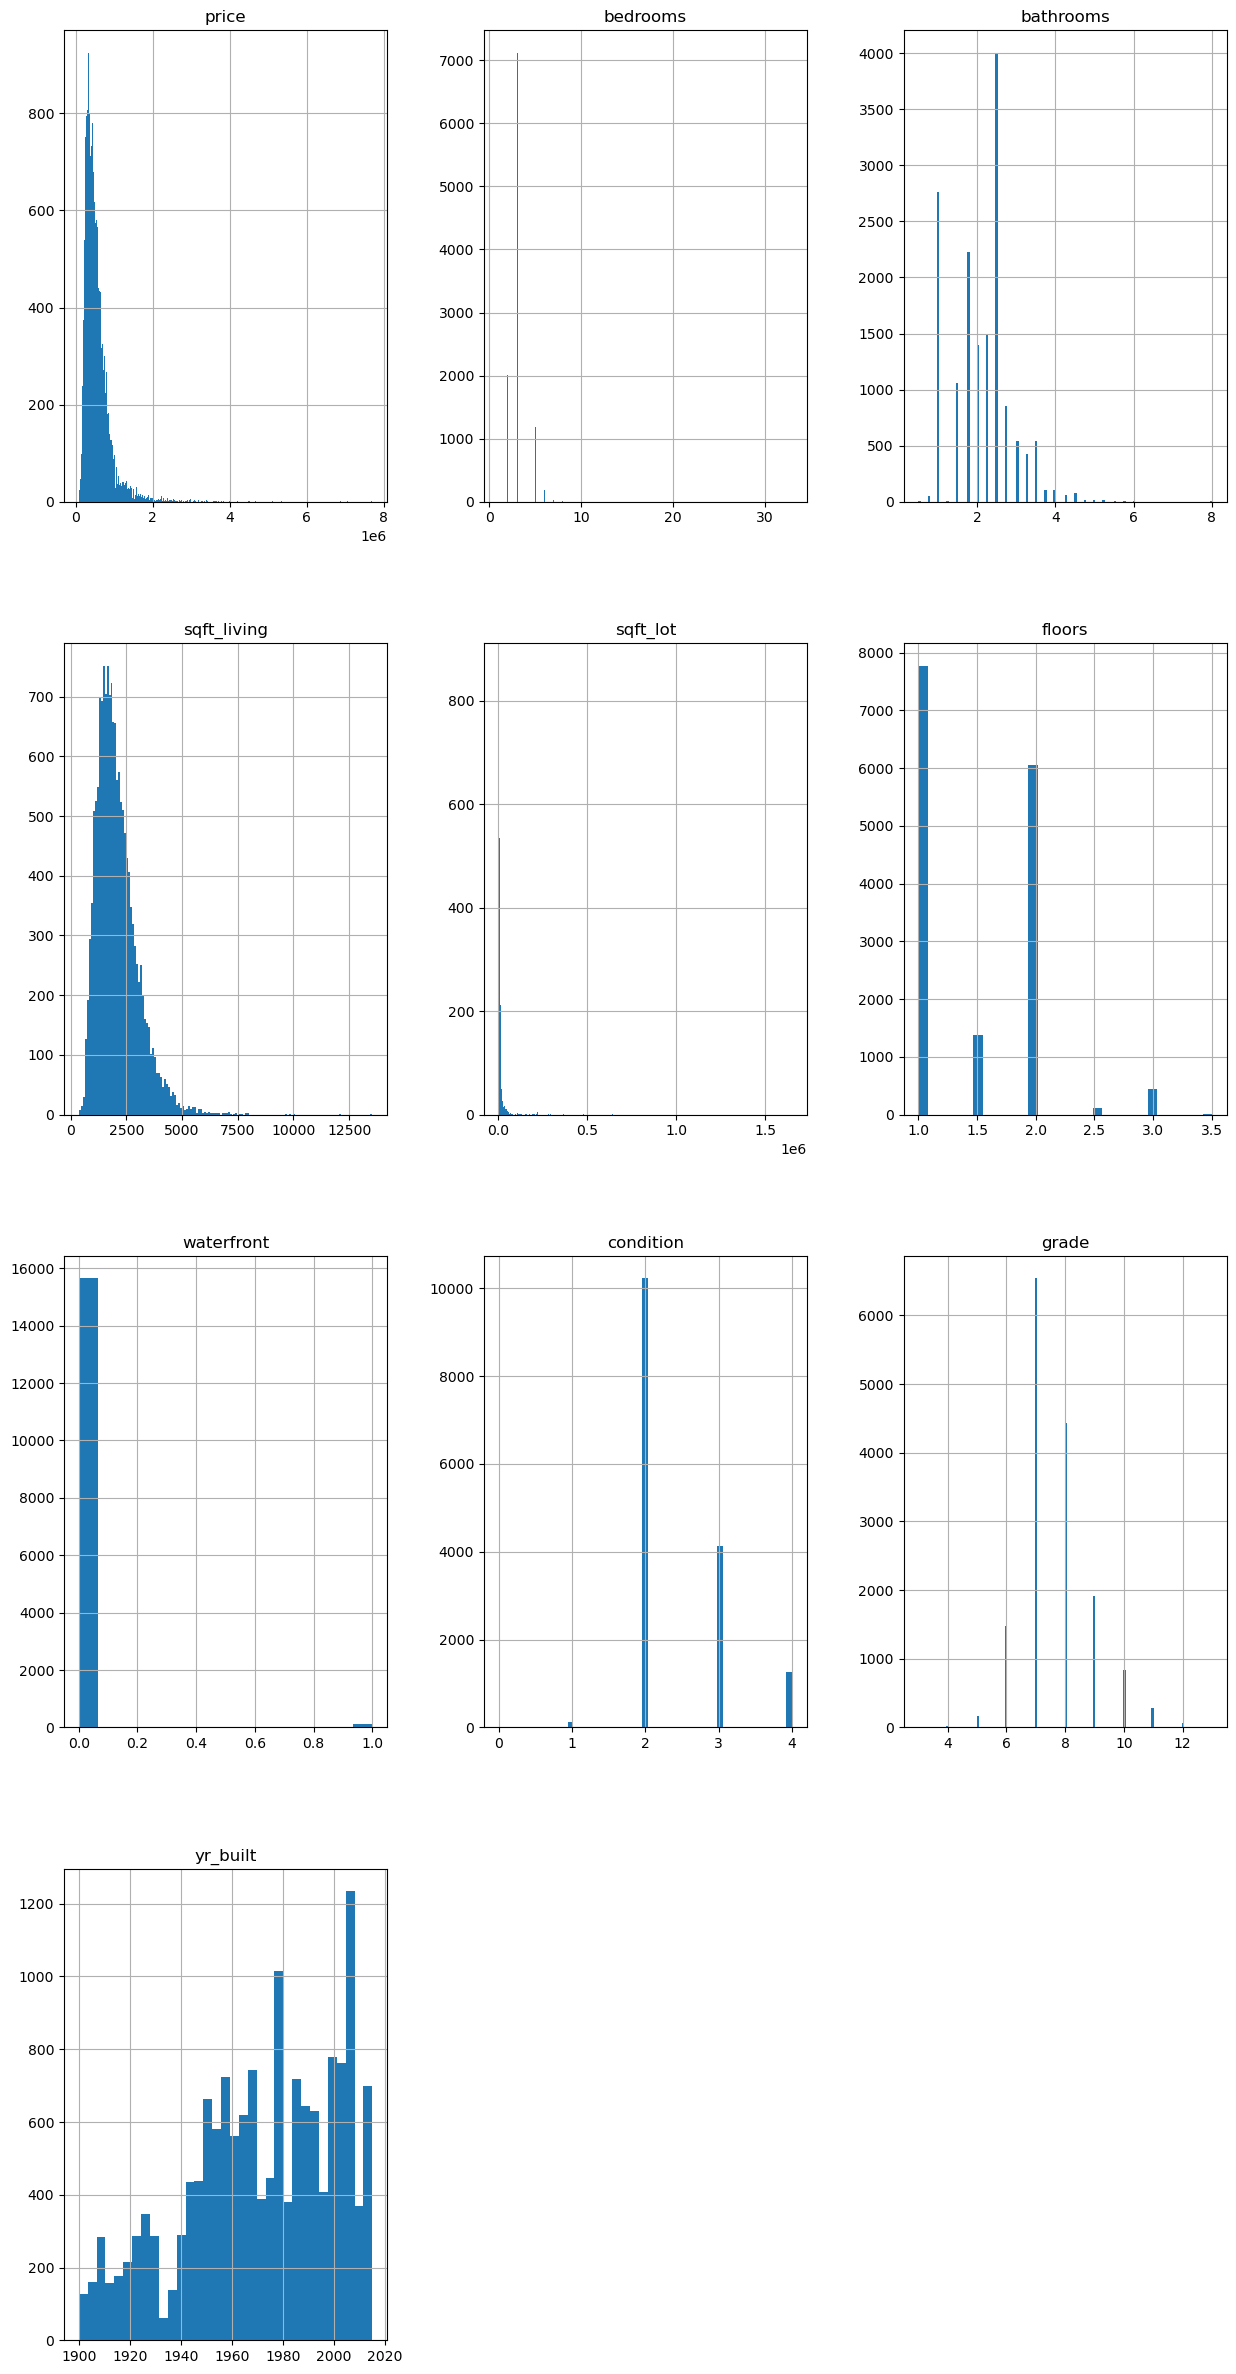

In [21]:
#First, let's plot a histogram for each column
housing_df.hist(figsize=(15, 30), bins='auto');

From the plots the variables bathrooms, bedrooms, condition, floors, grade, view, waterfront, and yr_renovated are categorical in nature. The remaining variables seem to be continuous. Let's explore this further by creating some plots.

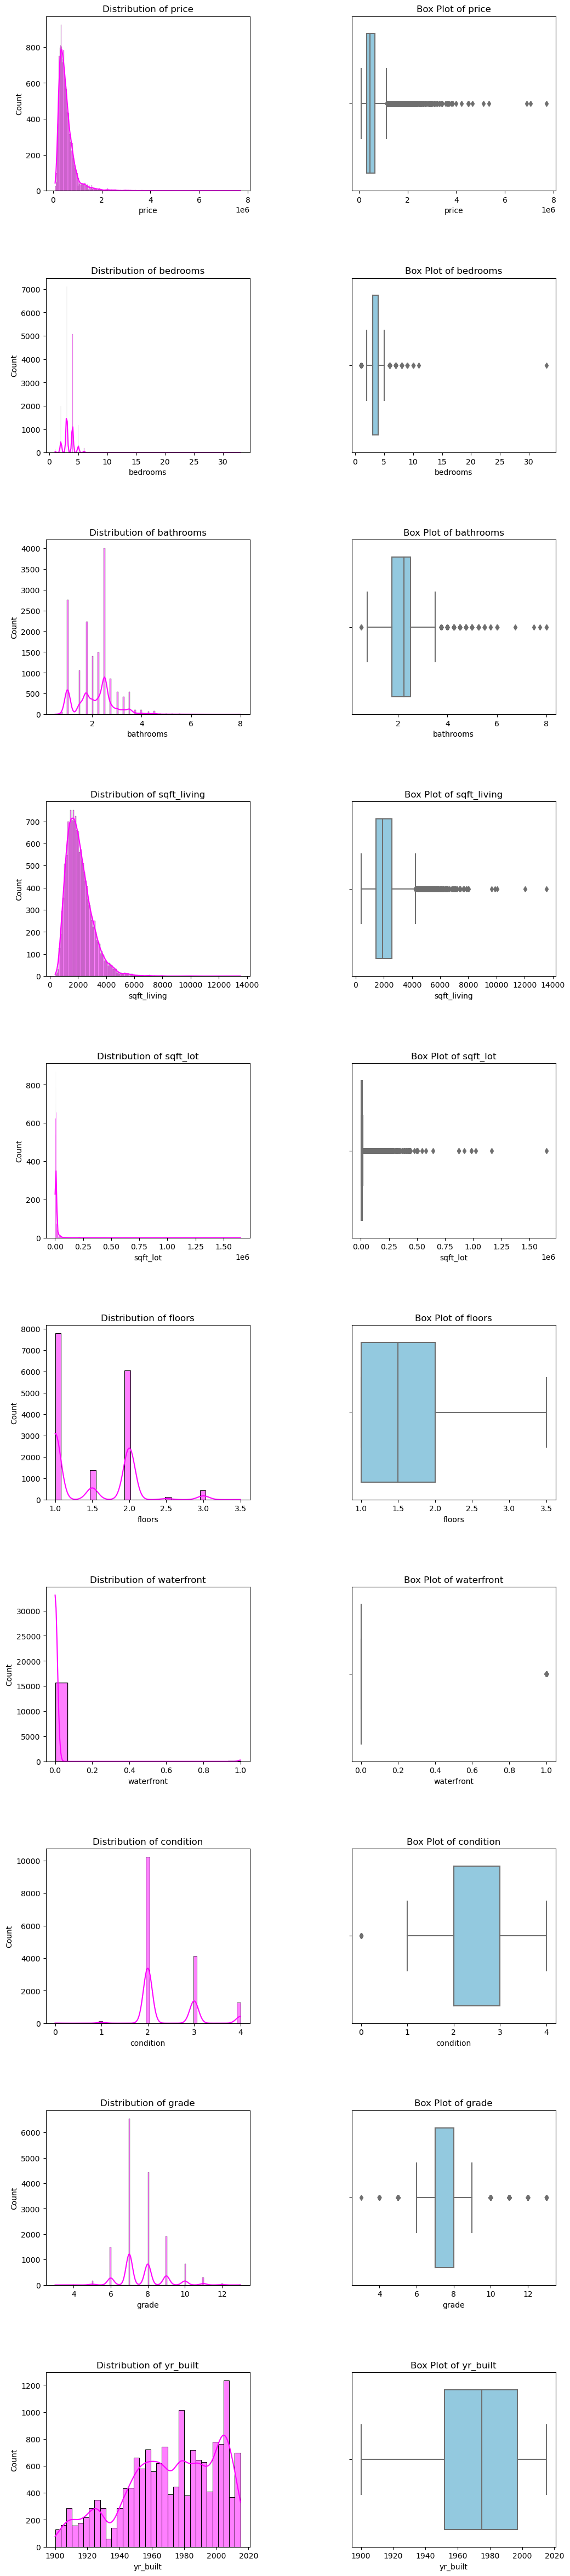

In [22]:
# Select only numerical columns for plotting
numerical_columns = housing_df.select_dtypes(include=['number'])

# Set up subplots for distribution plots
fig, axes = plt.subplots(nrows=len(numerical_columns.columns), ncols=2, figsize=(12, 6 * len(numerical_columns.columns)))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

# Create distribution plots (histograms or KDE plots)
for i, column in enumerate(numerical_columns.columns):
    ax = axes[i, 0]
    
    sns.histplot(data=numerical_columns, x=column, kde=True, color='magenta', ax=ax)
    
    ax.set_xlabel(column)
    ax.set_title(f'Distribution of {column}')

# Create box plots for presence of outliers
for i, column in enumerate(numerical_columns.columns):
    ax = axes[i, 1]
    
    sns.boxplot(data=numerical_columns, x=column, color='skyblue', ax=ax)
    
    ax.set_xlabel(column)
    ax.set_title(f'Box Plot of {column}')

# Show the plots
plt.show()

The plots have assisted us in confirming the nature of our variables, distinguishing between categorical and continuous ones. Among our variables, we have identified several as continuous, including sqft_living, sqft_lot, sqft_above, sqft_basement, yr_built, sqft_living15, and sqft_lot15. In the subsequent analysis, we will explore potential transformations for some of these continuous variables, as many of them currently exhibit deviations from a normal distribution.

In [23]:
housing_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
count,1.576200e+04,15762.000000,15762.000000,15762.000000,1.576200e+04,15762.000000,15762.000000,15762.000000,15762.000000,15762.000000
mean,5.413172e+05,3.378949,2.120797,2084.512372,1.528082e+04,1.495147,0.007613,2.410862,7.663748,1971.111217
std,3.722258e+05,0.935301,0.766772,918.617686,4.182288e+04,0.539352,0.086924,0.651961,1.172238,29.336823
min,8.200000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,3.000000,1900.000000
25%,3.210000e+05,3.000000,1.750000,1430.000000,5.048500e+03,1.000000,0.000000,2.000000,7.000000,1952.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.602000e+03,1.500000,0.000000,2.000000,7.000000,1975.000000
75%,6.448750e+05,4.000000,2.500000,2550.000000,1.072000e+04,2.000000,0.000000,3.000000,8.000000,1997.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,13.000000,2015.000000


In [24]:
# using the min - max can be useful for identifying potential outliers based on extreme values compared to the typical range within each column
housing_df.agg(['min', 'max'])

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
min,82000,1,0.5,370,520,1.0,0,0,3,1900
max,7700000,33,8.0,13540,1651359,3.5,1,4,13,2015


By performing this comparison, we can identify potential outliers in each column. If the minimum value is less than the lower bound or the maximum value is greater than the upper bound, it suggests the presence of outliers in that particular column

In [25]:
def remove_outliers(df, columns_to_check, outlier_threshold=1.5):
    """
    Remove outliers from a DataFrame based on the Interquartile Range (IQR) method.

    Parameters:
    - df: DataFrame
        The input DataFrame containing the data.
    - columns_to_check: list
        A list of column names in the DataFrame to check for outliers.
    - outlier_threshold: float, optional (default=1.5)
        The threshold for identifying outliers based on the IQR method. You can adjust this value.

    Returns:
    - None: The function directly modifies the input DataFrame to remove outliers.
    """

    for column in columns_to_check:
        # Calculate the first quartile (Q1) and third quartile (Q3)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)

        # Calculate the interquartile range (IQR)
        IQR = Q3 - Q1

        # Define the lower and upper bounds for outlier detection
        lower_bound = Q1 - outlier_threshold * IQR
        upper_bound = Q3 + outlier_threshold * IQR

        # Remove outliers based on the bounds
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Specify the columns to check for outliers (excluding 'numerical_grade' if it doesn't exist)
columns_to_check = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors']

# Set the outlier threshold
outlier_threshold = 1.5

# Call the function to remove outliers (modifies housing_df directly)
remove_outliers(housing_df, columns_to_check, outlier_threshold)

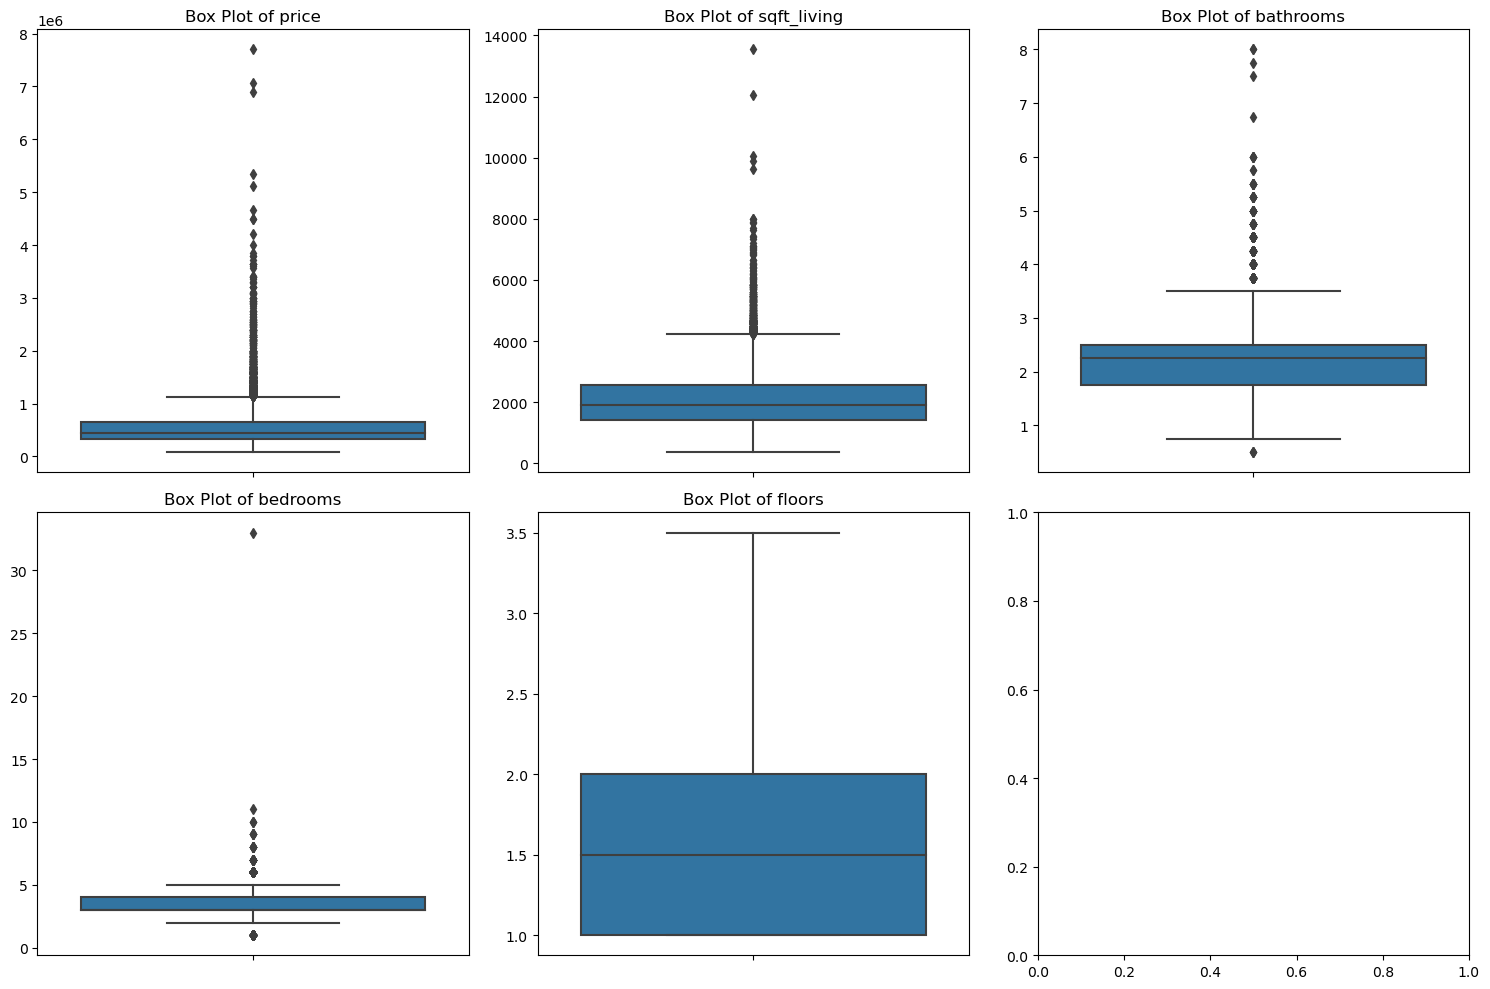

In [26]:
#Select the variables with potential outliers
variables_of_interest = ['price', 'sqft_living', 'bathrooms', 'bedrooms', 'floors']

# Create subplots for box plots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Iterate through the variables and create box plots
for i, var in enumerate(variables_of_interest):
    sns.boxplot(data=housing_df, y=var, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Box Plot of {var}')
    axes[i // 3, i % 3].set_ylabel('')
    axes[i // 3, i % 3].set_xlabel('')

# Adjust subplot layout
plt.tight_layout()
plt.show()

## Exploratory Data Analysis

For this project we will conduct the following analysis to explore relationships between the variables and identify potential predictors for property prices.

# Univariate Analysis
We conduct a univariate analysis to understand the distribution and characteristics of individual dependent and independent variables.

Below represents a univariate analysis function that individual column information and visualizes/ plots their distribution.

In [27]:
def univariate_analysis(data):
    # Univariate analysis for all columns
    for column in data.columns:
        if data[column].dtype in ['int64', 'float64']:
            # Display summary statistics for numerical columns
            print(data[column].describe())
            sns.histplot(data=data, x=column, kde=True)
            plt.title(f'Univariate Analysis of {column}')
            plt.show()
        else:
            # Display countplot for categorical columns
            print(data[column].value_counts())
            sns.countplot(data=data, x=column)
            plt.title(f'Univariate Analysis of {column}')
            plt.xticks(rotation=45)
            plt.show()

count    1.576200e+04
mean     5.413172e+05
std      3.722258e+05
min      8.200000e+04
25%      3.210000e+05
50%      4.500000e+05
75%      6.448750e+05
max      7.700000e+06
Name: price, dtype: float64


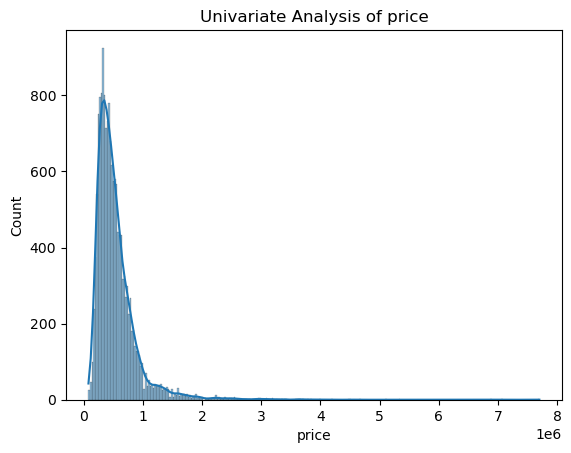

count    15762.000000
mean         3.378949
std          0.935301
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64


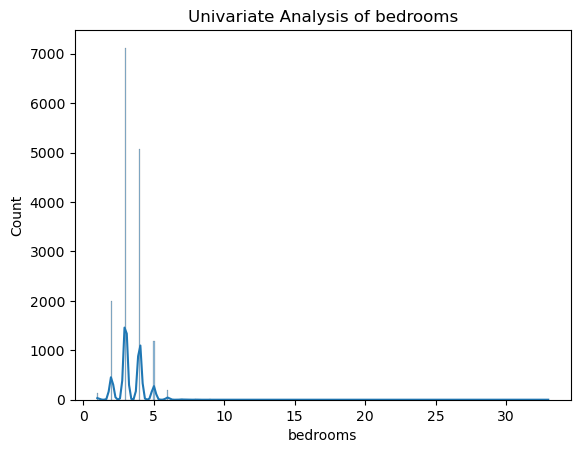

count    15762.000000
mean         2.120797
std          0.766772
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64


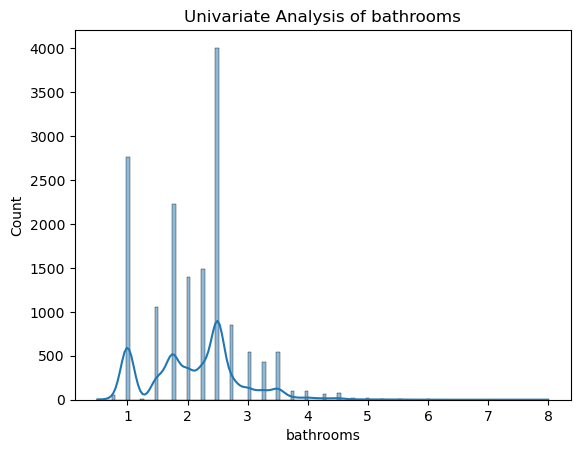

count    15762.000000
mean      2084.512372
std        918.617686
min        370.000000
25%       1430.000000
50%       1920.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64


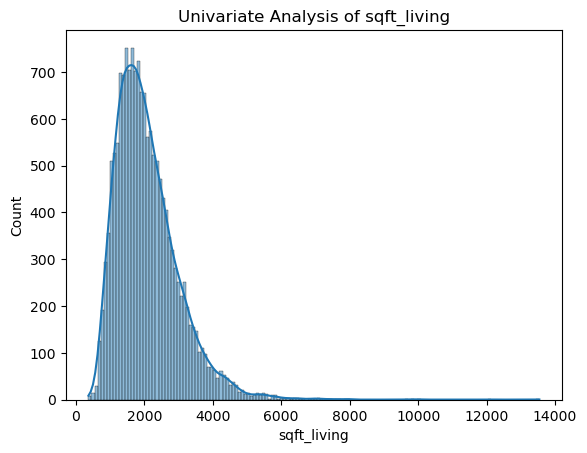

count    1.576200e+04
mean     1.528082e+04
std      4.182288e+04
min      5.200000e+02
25%      5.048500e+03
50%      7.602000e+03
75%      1.072000e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64


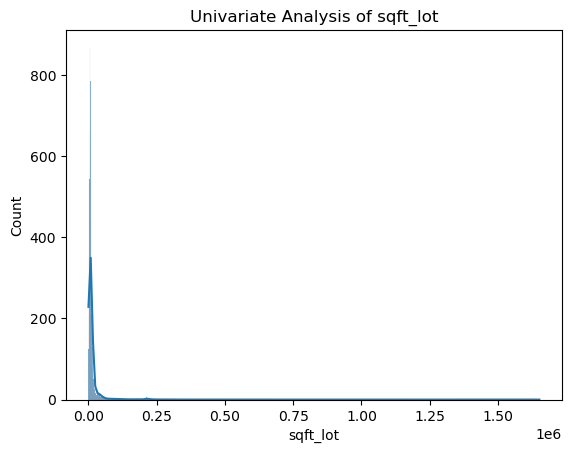

count    15762.000000
mean         1.495147
std          0.539352
min          1.000000
25%          1.000000
50%          1.500000
75%          2.000000
max          3.500000
Name: floors, dtype: float64


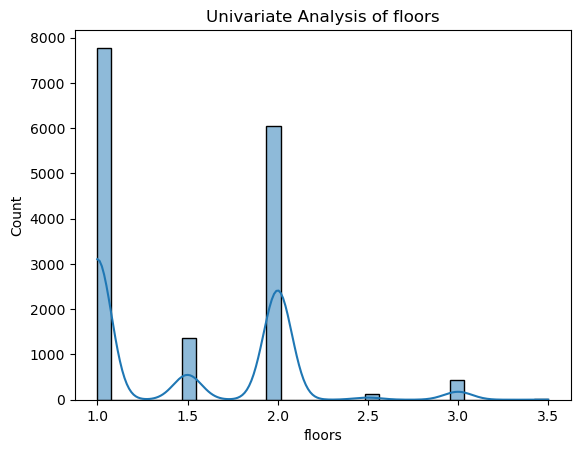

count    15762.000000
mean         0.007613
std          0.086924
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: waterfront, dtype: float64


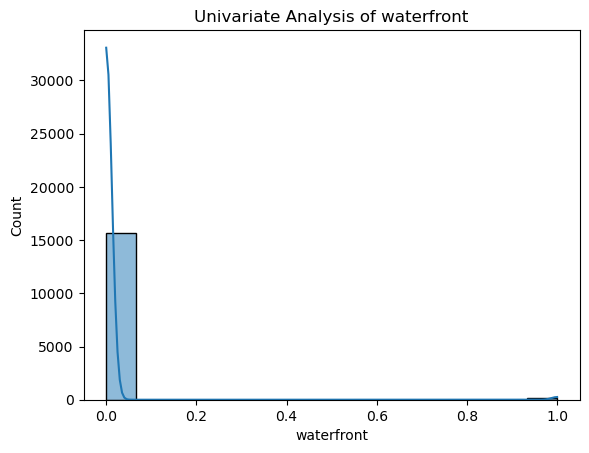

count    15762.000000
mean         2.410862
std          0.651961
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: condition, dtype: float64


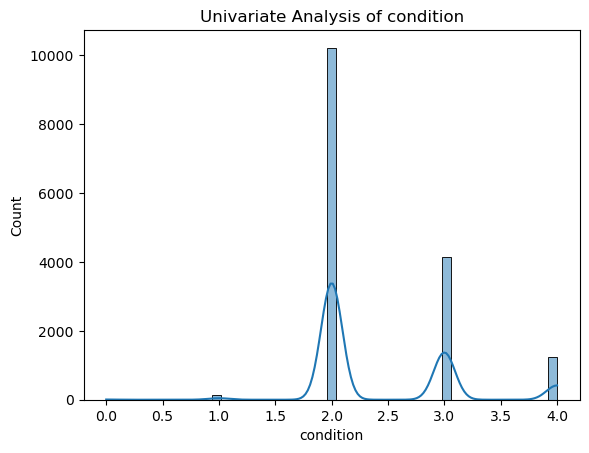

count    15762.000000
mean         7.663748
std          1.172238
min          3.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64


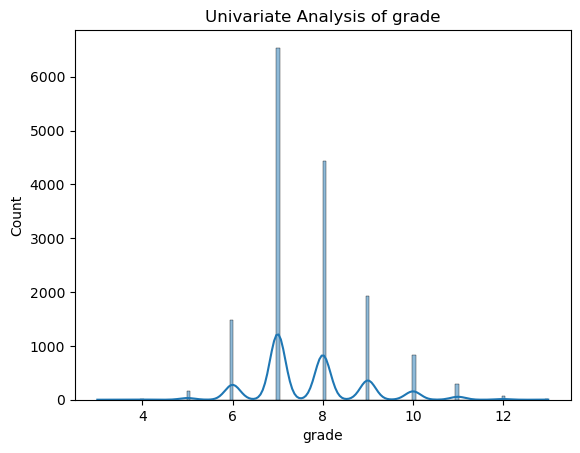

count    15762.000000
mean      1971.111217
std         29.336823
min       1900.000000
25%       1952.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64


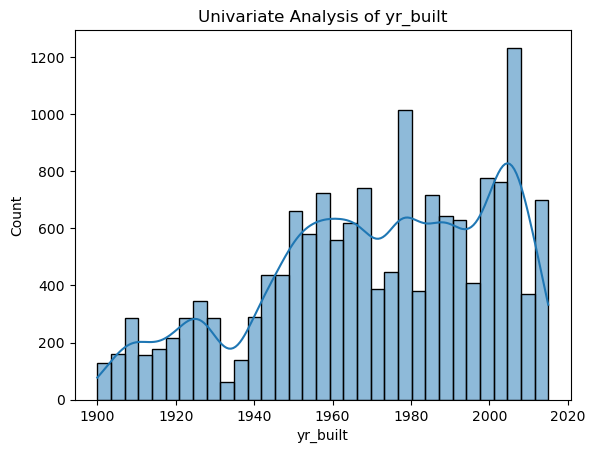

In [28]:
# Perform univariate analysis for all columns in housing_df
univariate_analysis(housing_df)

# Objective 1. What type of features mostly attract customers to buying house?

# Multivariate Analysis
We conduct a multivariate analysis to understand the correlation multiple independent and dependent variables.

In our case this will be used to understand the relationship between house features and price(target variable)

Below represents a multivariate analysis function that will be used to visualize their correlation.

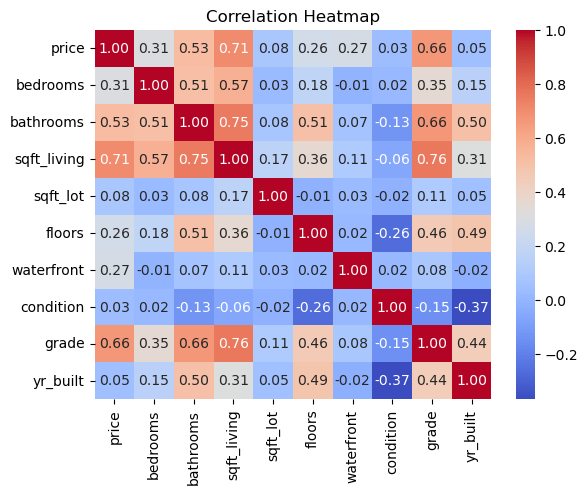

In [29]:
def multivariate_analysis(data):
    """Perform multivariate analysis on the data"""
    
    # Calculate the pairwise Pearson correlation coefficients for all columns
    corr_matrix = data.corr(numeric_only=True)  # Set numeric_only=True to exclude non-numeric columns
    
    # Plot a heatmap to visualize the correlations
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

# Call the function with your DataFrame
multivariate_analysis(housing_df)

The size of the living area, indicated by sqft_living has the strongest positive impact on property prices. The number of bathrooms also significantly influences prices. Bedrooms, while still positively correlated, have a comparatively weaker impact. Other attributes like floors, sqft_living15, and yr_built show moderate correlations with various features.
These correlation findings can guide feature selection and provide insights into potential predictors for property price prediction models.

# Objective 2. How do the various  house features affect the valuation of a property?

Multicollinearity Check

We conduct this check to verify if there is highly correlated predictors that might affect the stability of the regression model.

In [43]:
def multicollinearity_check(df, threshold):
    '''
    Enter a DataFrame and threshold for multicollinearity
    Returns pairs of variables with high correlation coefficients
    indicating multicollinearity.
    '''
    # Exclude non-numeric columns from the DataFrame
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the correlation matrix and absolute values
    corr_matrix = numeric_df.corr().abs()
    
    # Create a mask to identify highly correlated variables
    mask = (corr_matrix > threshold) & (corr_matrix < 1)
    
    # Find the indices of highly correlated variables
    multicollinear_indices = np.where(mask)
    
    # Create a list to store pairs of multicollinear variables
    multicollinear_pairs = []
    
    # Iterate through the indices and add pairs to the list
    for i, j in zip(*multicollinear_indices):
        var1 = numeric_df.columns[i]
        var2 = numeric_df.columns[j]
        corr_coef = corr_matrix.iloc[i, j]
        multicollinear_pairs.append((var1, var2, corr_coef))
    
    return multicollinear_pairs

# Call the function with your DataFrame
multicollinearity_check(housing_df, 0.8)


[]

The multicollinearity_check helped us identify pairs of variables in our housing dataset that are closely related to each other. We found no incidences of multicollinearity

# Regression Modeling
We will now run a baseline linear regression model using various features as predictors, including the number of bedrooms, bathrooms, square footage of living space, square footage of the lot, number of floors, waterfront status, house condition, and grade.

In [31]:
y = housing_df['price']
x = housing_df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade']]
base_model = sm.OLS(y, sm.add_constant(x)).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2889.
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:18:29   Log-Likelihood:            -2.1743e+05
No. Observations:               15762   AIC:                         4.349e+05
Df Residuals:                   15753   BIC:                         4.349e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.494e+05   1.92e+04    -33.819      0.000   -6.87e+05   -6.12e+05
bedrooms    -3.963e+04   2567.102    -15.437      0.000   -4.47e+04   -3.46e+04
bathrooms    -1.08e+04   4160.663     -2.595      0.009    -1.9e+04   -2640.763
sqft_living   217.5924      4.121     52.795      0.000     209.514     225.671
sqft_lot       -0.3421      0.046     -7.417      0.000      -0.432      -0.252
floors      -1.983e+04   4293.818     -4.618      0.000   -2.82e+04   -1.14e+04
waterfront   8.068e+05    2.2e+04     36.752      0.000    7.64e+05     8.5e+05
condition    5.888e+04   3019.509     19.501      0.000     5.3e+04    6.48e+04
grade        1.019e+05   2689.226     37.879      0.000    9.66e+04    1.07e+05
==============================================================================
Omnibus:                    11596.062   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           703026.022
Skew:                           2.961   Prob(JB):                         0.00
Kurtosis:                      35.178   Cond. No.                     5.18e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.18e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Model Evaluation:

The R-squared value is 0.595, which indicates that approximately 59.5% of the variance in the price can be explained by the independent variables. 
The linear regression model (Prob (F-statistic) 0.00) appears to be statistically significant and provides insights into the relationship between the given independent variables and the housing price. The model suggests that variables like 'grade,' 'sqft_living,' 'bathrooms,' and 'waterfront' have substantial impacts on the housing price. However, further analysis, including assessing the assumptions of linear regression and potential model improvements, would be necessary for a more comprehensive understanding of the model's accuracy and reliability.

## Assumptions of linear regreesion check

Up to this point, we've established that our analysis involves more than one independent variable. Consequently, it's crucial to ensure that the values of the independent variables adhere to the assumptions of linear regression. These assumptions include:

1. Linearity: The relationship between X and the mean of Y should be linear.
2. Normality: The residuals should be normally distributed.
3. Homoscedasticity: The variance of residuals should remain consistent for any value of X.
4. Independence: All observations must be independent of each other

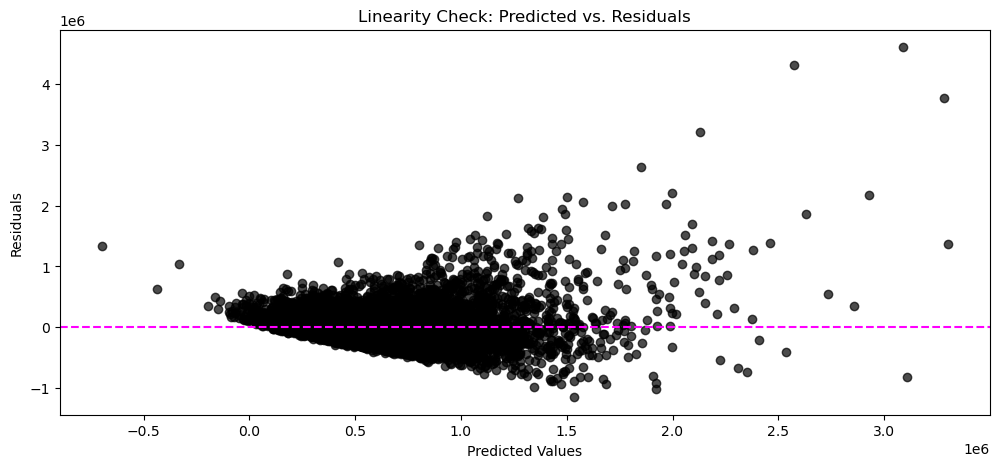

In [32]:
def linearity_check(model):
    """
    Visualizes the linearity assumption of a linear regression model.
    
    Parameters:
    - model: A fitted linear regression model.
    
    Displays a scatter plot of predicted values vs. residuals and a horizontal line at y=0.
    """
    
    # Calculate predicted values and residuals
    model_fitted_y = model.fittedvalues
    model_residuals = model.resid
    
    # Create a scatter plot
    plt.figure(figsize=(12, 5))
    plt.scatter(model_fitted_y, model_residuals, color='black', alpha=0.7)
    
    # Add a horizontal dashed line at y=0
    plt.axhline(y=0, color='magenta', linestyle='--')
    
    # Set labels and title
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Linearity Check: Predicted vs. Residuals')
    
    # Show the plot
    plt.show()

# Call the linearity_check function with your fitted linear regression model
linearity_check(base_model)

The model exhibits non-linearity because the residuals do not display a random distribution around the horizontal line at y=0.

2. Normality of Residuals: The residuals should be normally distributed. This assumption implies that the distribution of errors is symmetric and follows a bell-shaped curve

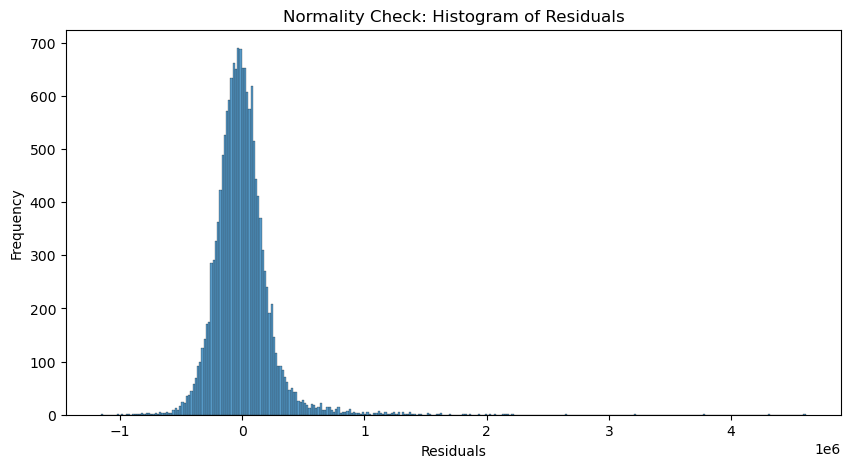

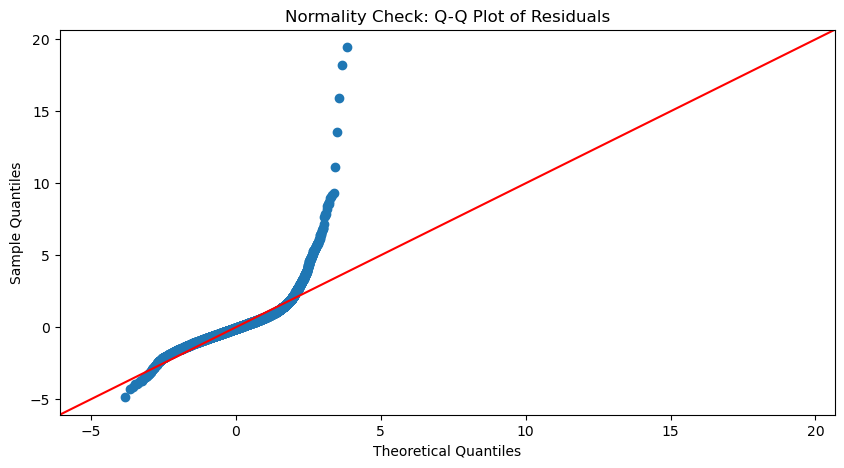

In [33]:
# Function to check the normality of residuals
def normality_check(residuals):
    # Create a histogram of residuals
    fig, ax1 = plt.subplots(figsize=(10, 5))
    sns.histplot(residuals, ax=ax1)  # Plot the histogram
    ax1.set_title('Normality Check: Histogram of Residuals')  # Set the title
    ax1.set_xlabel('Residuals')  # Label for the x-axis
    ax1.set_ylabel('Frequency')  # Label for the y-axis

    # Create a Q-Q plot of residuals
    fig, ax2 = plt.subplots(figsize=(10, 5))
    sm.qqplot(residuals, fit=True, line='45', ax=ax2)  # Plot the Q-Q plot
    ax2.set_xlabel('Theoretical Quantiles')  # Label for the x-axis
    ax2.set_ylabel('Sample Quantiles')  # Label for the y-axis
    ax2.set_title('Normality Check: Q-Q Plot of Residuals')  # Set the title

    # Show the plots
    plt.show()

# Call the normality_check function with the residuals from your base_model
normality_check(base_model.resid)

The model displays non-linearity because the residuals do not exhibit a normal distribution.

3. Homoscedasticity: The variance of residuals should remain consistent for any value of X. The code below checks for homoscedasticity, which means checking if the residuals (the differences between actual and predicted values) have consistent variance across the range of predicted values. Homoscedasticity is important for the validity of linear regression

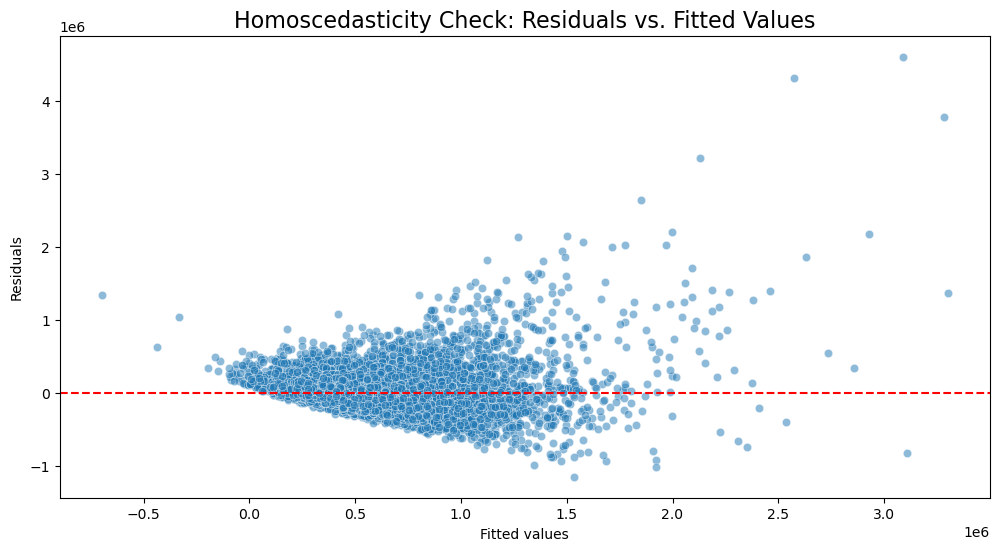

In [34]:
def homoscedasticity_check(model):
    # Get residuals and predicted values from the model
    model_residuals = model.resid
    model_fitted_y = model.fittedvalues
    
    # Create a scatterplot of residuals vs. predicted values
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.scatterplot(x=model_fitted_y, y=model_residuals, alpha=0.5, ax=ax)
    
    # Add a horizontal line at y=0
    ax.axhline(y=0, color='r', linestyle='--')
    
    # Label the axes and set the plot title
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
    ax.set_title('Homoscedasticity Check: Residuals vs. Fitted Values', fontsize=16)
    
    # Show the plot
    plt.show()

# Call the homoscedasticity_check function with your fitted linear regression model
homoscedasticity_check(base_model)

The variability of residuals does not remain constant across the entire range, resulting in a heteroscedastic pattern 

4. Independence
To examine the independence of residuals, create plots where the residuals are displayed against the order in which they were observed or time. The presence of any pattern or correlation suggests that the model might not be adequately accounting for all relevant information.

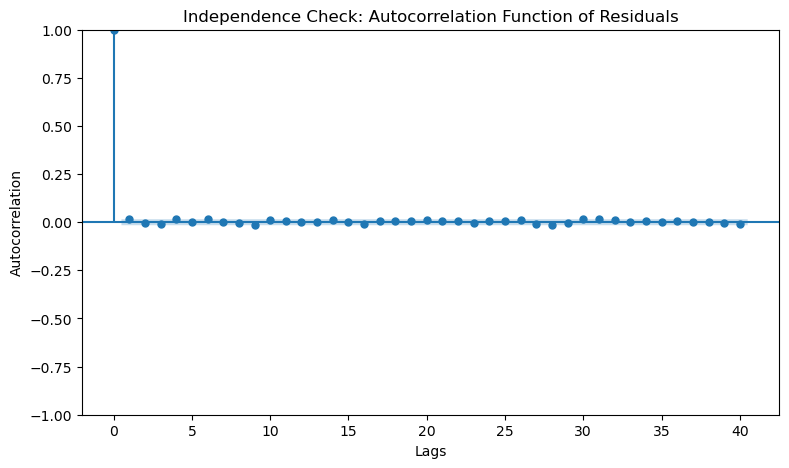

In [35]:
# plotting autocorrelation function of residuals
def independence_check(residuals):
    fig, ax = plt.subplots(figsize=(9,5))
    _ = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax)
    ax.set_xlabel('Lags')
    ax.set_ylabel('Autocorrelation')
    ax.set_title('Independence Check: Autocorrelation Function of Residuals')
    plt.show()
independence_check(base_model.resid)

The occurrence of a single peak beyond the confidence intervals indicates the existence of significant autocorrelation in the residuals, implying that the model is not fully accounting for all relevant information.

# Model Evaluation

In [36]:
def train_test(x, y):
    # Split the input data into training and testing sets using the "train_test_split" method from scikit-learn.
    # Use a test size of 0.3 and a random state of 42.
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    
    # Create a LinearRegression object and train it using the training data.
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)
    
    # Make predictions using the trained model for both the training and testing data.
    y_hat_train = linreg.predict(x_train)
    y_hat_test = linreg.predict(x_test)
    
    # Print the R-squared value for the testing data.
    r_squared = r2_score(y_test, y_hat_test)
    print('R-squared:', r_squared, '\n')
    
    # Calculate the mean absolute error and mean squared error for both the training and testing data.
    train_mae = mean_absolute_error(y_train, y_hat_train)
    test_mae = mean_absolute_error(y_test, y_hat_test)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    
    # Print the mean absolute error and mean squared error for both the training and testing data.
    print('Train MAE:', train_mae)
    print('Test MAE:', test_mae, '\n')
    print('Train MSE:', train_mse)
    print('Test MSE:', test_mse, '\n')
    
    # Print the root mean squared error for both the training and testing data.
    print('Train RMSE:', np.sqrt(train_mse))
    print('Test RMSE:', np.sqrt(test_mse), '\n')
    
    # Create a scatter plot comparing the predicted values to the actual values for both the training and testing data.
    plt.figure(figsize=(10, 6))

    plt.scatter(y_train, y_hat_train, alpha=0.5, color='#00BFFF', label='Train')
    sns.regplot(x=y_train, y=y_hat_train, scatter=False, color='r', label='Train Fit')

    plt.scatter(y_test, y_hat_test, alpha=0.5, color='#FFC0CB', label='Test')
    sns.regplot(x=y_test, y=y_hat_test, scatter=False, color='g', label='Test Fit')

    plt.scatter(x=y, y=y, color='maroon', alpha=0.3, label='Actual')

    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title('Actual Price vs Predicted Price')

    plt.legend()
    plt.grid()
    plt.show()
    
    # Use statsmodels to get detailed statistics about the model
    x_train_sm = sm.add_constant(x_train)  # Add a constant (intercept) to the model
    model = sm.OLS(y_train, x_train_sm).fit()  # Fit the model
    summary = model.summary()  # Get the summary
    
    # Print the model summary which includes coefficients, p-values, and F-statistic
    print(summary)
    
    # Create a new LinearRegression object and train it using the training data.
    ml = LinearRegression()
    ml.fit(x_train, y_train)
    
    # Use the new model to make predictions for the testing data.
    y_pred = ml.predict(x_test)
    
    # Create a DataFrame containing the actual values, predicted values, difference, and percentage difference for the testing data.
    pred_y_df = pd.DataFrame({'Actual Values': y_test, 'Predicted Value': y_pred, 'Difference': abs(y_test - y_pred), 'Percentage Difference': abs((y_test - y_pred) / y_test * 100)})
    
    # Calculate the mean percentage difference between the actual and predicted values for the testing data.
    mean_percentage = pred_y_df['Percentage Difference'].mean()
    
    # Print the mean percentage difference for the testing data.
    print('Mean Percentage Difference:', mean_percentage)
    
    # Return the first 5 rows of the DataFrame
    return pred_y_df.head()

R-squared: 0.6537191985968421 

Train MAE: 144802.43918438107
Test MAE: 143415.89187891674 

Train MSE: 50876144092.466225
Test MSE: 43740180723.43627 

Train RMSE: 225557.40753179937
Test RMSE: 209141.53275577826 



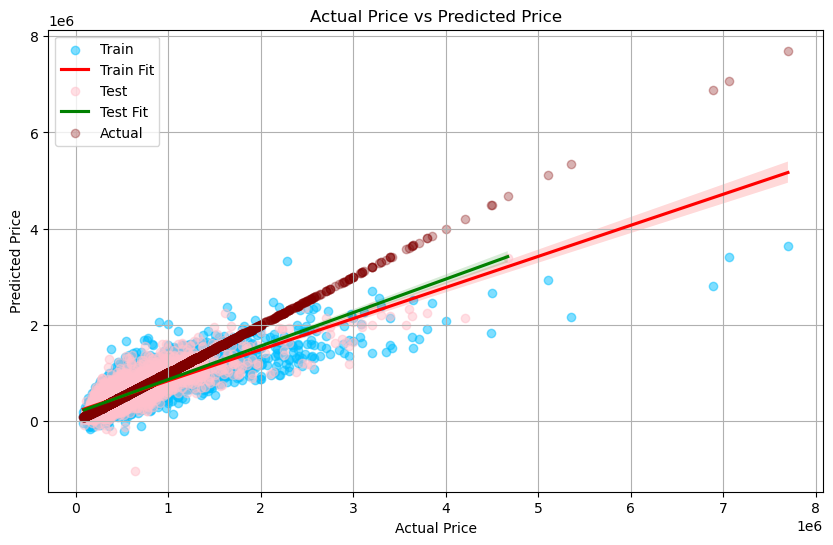

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     2236.
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:18:36   Log-Likelihood:            -1.5165e+05
No. Observations:               11033   AIC:                         3.033e+05
Df Residuals:                   11023   BIC:                         3.034e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.975e+06   1.88e+05     37.148      

,Actual Values,Predicted Value,Difference,Percentage Difference
8446,340000,360245.836586,20245.836586,5.954658
7473,320000,247669.922789,72330.077211,22.603149
20534,230000,226599.827686,3400.172314,1.478336
5063,479990,440058.108555,39931.891445,8.319317
17989,715000,241706.778248,473293.221752,66.194856


In [37]:
x = housing_df.drop(['price'], axis=1)
y = housing_df.price
train_test(x,y)

R-squared (R²): R-squared value is approximately 0.6537, this is the R-squared value for the linear regression model that was initially trained. It represents the goodness-of-fit of the model on the testing data. R-squared value is approximately of 0.646 is specifically calculated and reported as part of the detailed results of the linear regression analysis using the statsmodels library.
The R-squared indicates that approximately 65.37% and 64.6% of the variance in the target variable (price) is explained by the independent variables (features) included in your model.

Mean Absolute Error (MAE):
MAE measures the average absolute difference between the actual and predicted values. In this case, it shows that, on average, the model's predictions have an error of around 144,802 dollars for the training set  and  143416 dollars for the test set. This error represents the average magnitude of the model's mistakes in predicting house prices.

Mean Squared Error (MSE):
MSE calculates the average squared difference between actual and predicted values. The training and test MSE values are both quite large, indicating that the model's errors are spread out over a wide range. This suggests that the model can make large prediction errors for some houses.

Root Mean Squared Error (RMSE):
RMSE is the square root of MSE and provides a measure of the average magnitude of errors in the same unit as the target variable. The RMSE values suggest that, on average, the model's predictions have an error of around 225,557 dollars for the training set  and 209,141 dollars for the test set.

In summary, the model explains a moderate amount of the variance in house prices, but there is room for improvement. The MAE, MSE, and RMSE values suggest that the model can make relatively large prediction errors, and the mean percentage difference indicates that predictions, on average, have a significant percentage difference from the actual prices. 

In summary, the above metrics suggest that the linear regression model is not performing very well in terms of making accurate predictions.

# Log Transformation Model

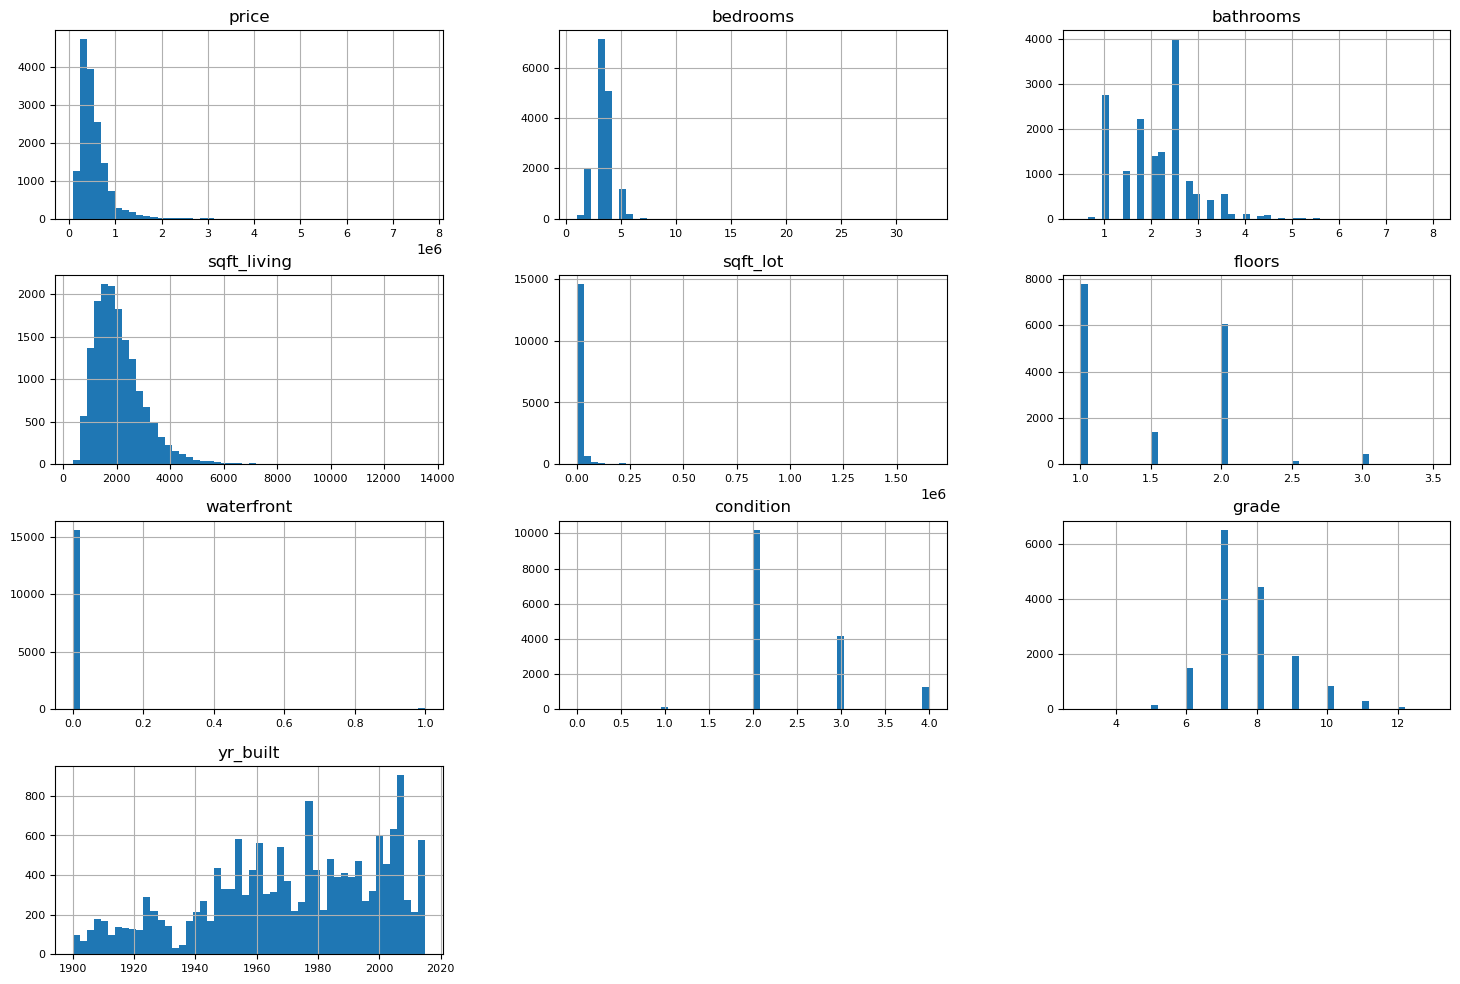

In [38]:
# Copying the base model dataframe
log_housing_df = housing_df.copy()

# Plotting histograms of all the variables
log_housing_df.hist(figsize=(18,12), bins=50, xlabelsize=8, ylabelsize=8);

In [39]:
colums_transform = ['price']

for col in colums_transform:
    log_housing_df[col] = np.log(log_housing_df[col])

log_housing_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,yr_built
1,13.195614,3,2.25,2570,7242,2.0,0,2,7,1951
3,13.311329,4,3.00,1960,5000,1.0,0,4,7,1965
4,13.142166,3,2.00,1680,8080,1.0,0,2,8,1987
5,14.022525,4,4.50,5420,101930,1.0,0,2,11,2001
6,12.458775,3,2.25,1715,6819,2.0,0,2,7,1995


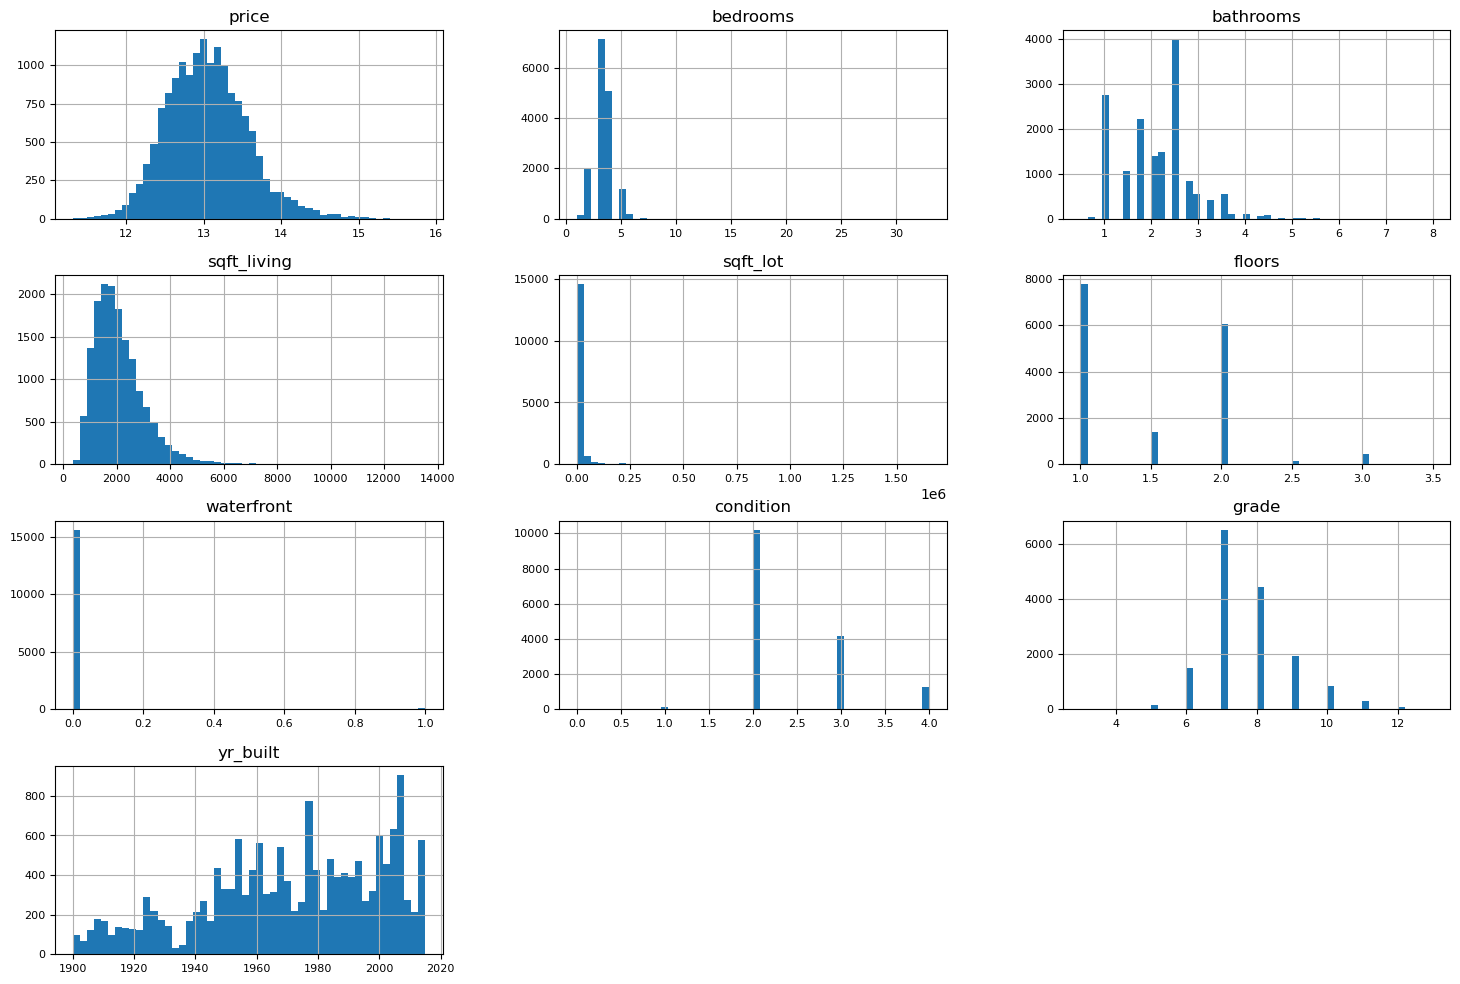

In [40]:
# Plotting histograms of all log transformed variables
log_housing_df.hist(figsize=(18,12), bins=50, xlabelsize=8, ylabelsize=8);

R-squared: 0.6320876343533641 

Train MAE: 0.2506293607775718
Test MAE: 0.25277306170580355 

Train MSE: 0.09899805266823854
Test MSE: 0.09991324497991846 

Train RMSE: 0.31463955992252235
Test RMSE: 0.3160905645221294 



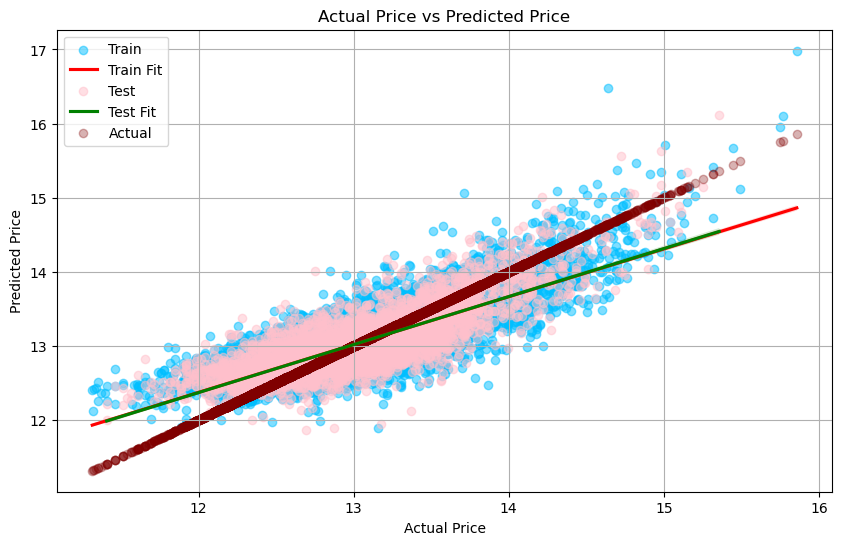

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     2230.
Date:                Mon, 11 Sep 2023   Prob (F-statistic):               0.00
Time:                        01:18:48   Log-Likelihood:                -2897.4
No. Observations:               11033   AIC:                             5815.
Df Residuals:                   11023   BIC:                             5888.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          22.0930      0.262     84.355      

,Actual Values,Predicted Value,Difference,Percentage Difference
8446,12.736701,12.789327,0.052626,0.413183
7473,12.676076,12.639303,0.036773,0.290097
20534,12.345835,12.701204,0.355370,2.878458
5063,13.081521,12.927647,0.153873,1.176266
17989,13.480038,12.527613,0.952425,7.065450


In [41]:
# Defining the target variable and the independent variables
yl = log_housing_df.price
Xl = log_housing_df.drop('price', axis=1)

# train test 
train_test(Xl,yl)

Log Transformation Model Evaluation:

R-squared (R²):

Original Model: R-squared is higher (0.6537) compared to the Log-Transformed Model (0.6321). This suggests that the original model explains a slightly larger proportion of the variance in the target variable (price).

Mean Absolute Error (MAE) and Mean Squared Error (MSE):

Original Model: The MAE and MSE values in the original model are in the range of thousands and billions, respectively, because the target variable is not log-transformed.
Log-Transformed Model: The MAE and MSE values in the log-transformed model are much smaller (around 0.25 for MAE and 0.1 for MSE), as they are in log-transformed units.
Root Mean Squared Error (RMSE):

Original Model: The RMSE values in the original model are relatively large due to the scale of the target variable.
Log-Transformed Model: The RMSE values in the log-transformed model are much smaller and in log-transformed units.
Mean Percentage Difference:

The original model has a higher R-squared value, indicating that it explains slightly more of the variance in house prices.
However, the log-transformed model has significantly smaller Mean Absolute Error, Mean Squared Error, and Root Mean Squared Error values, suggesting that it provides more accurate predictions in log-transformed units.

# Results and Findings
Results:

The initial linear regression model had an R-squared value of approximately 0.645, indicating that around 64.5% of the variance in property prices could be explained by the selected features. This means that the features of the property relatively affect the overall price.

The log-transformed model though with a slightly lower R-squared resulted in lower errors, indicating better predictive accuracy for log-transformed prices.

Findings
Bedrooms:One of the predictor variables. Its coefficient is -0.0278, which indicates that for each unit increase in the number of bedrooms, the dependent variable (price) decreases by approximately 0.0278 units.

Bathrooms: This is another predictor variable. Its coefficient is 0.0890, indicating that for each additional bathroom, the dependent variable(price) increases by approximately 0.0890 units.

sqft_living: This is a predictor variable representing the square footage of living space. Its coefficient is 0.0002, suggesting that for each additional square foot of living space, the dependent variable(price) increases by approximately 0.0002 units.

sqft_lot: This is another predictor variable representing the square footage of the lot. Its coefficient is very small and negative (-2.002e-08), but it's not statistically significant since its p-value is 0.787, indicating that it may not be significant in terms of predicting price.

Floors: The coefficient for the "floors" variable is 0.0818. This suggests that, holding all other variables constant, for each additional floor in a house, the predicted value of the dependent variable (e.g., house price) increases by approximately 0.0818 units.

Waterfront: The coefficient for the "waterfront" variable is 0.4698. Since "waterfront" is likely a binary variable (0 for no waterfront and 1 for waterfront), this coefficient indicates that having a waterfront property increases the predicted value of the dependent variable(price) by 0.4698 units compared to non-waterfront properties. 

Condition: The coefficient for the "condition" variable is 0.0405. This suggests that, holding all other variables constant, for each unit increase in the condition rating of a property, the predicted value of the dependent variable(price) increases by approximately 0.0405 units.

Grade: The coefficient for the "grade" variable is 0.2242. This indicates that, holding all other variables constant, for each unit increase in the property grade rating, the predicted value of the dependent variable(price) increases by approximately 0.2242 units.

All the independent variables aside from sqft_lot have a p-value of 0.00 which indicates their significance in predicting price.

# Conclusion

The following conclusions were drawn from this project and were used to answer the the business problem as stated earlier on.

1. Predictive power of the model
The original linear regression model explains a moderate amount of variance in house prices based on the selected features. However, it exhibits relatively high prediction errors in dollars.

The log-transformed linear regression model, while slightly lower in R-squared, shows lower prediction errors on both the log-transformed and original scales. This suggests that the log-transformed model may provide more accurate predictions, especially when considering relative percentage differences.


2. Key Factors Affecting House Prices:

The coefficients of the independent variables in the model provide insights into their impact on house prices in the northwestern county.

price = 22.0930 - 0.0278 * bedrooms + 0.0890 * bathrooms + 0.0002 * sqft_living - 2.002 * 10^(-8)* sqft_lot + 0.0818 * floors + 0.4698 * waterfront + 0.0405 * condition + 0.2242 * grade - 0.0058 * yr_built

Positive Factors: Variables such as the number of bathrooms, square footage of living space (sqft_living), the presence of a waterfront view (waterfront), and the overall grade of the property (grade) have positive coefficients. An increase in these factors is associated with higher house prices.

Negative Factors: The number of bedrooms (bedrooms) and the year built (yr_built) have negative coefficients. This implies that an increase in the number of bedrooms or an older year of construction may lead to lower house prices.

Less Impactful Factors: Square footage of the lot (sqft_lot), the number of floors (floors), and the condition of the property (condition) also play a role in house prices but to a lesser extent.

Customer satisfaction, knowing the above features have an influemce on the buyers decision, the stakeholder can advice on what renovations are most marketable.

# Recommendation

1. I would suggest conducting additional analysis to pinpoint the factors that are influencing the model's predictions. It might be beneficial to explore the inclusion of new variables that could enhance the model's accuracy. for example crime data by zip code, school rating data by school zone, and including more years of data.

2. Temporal Effects: Explore whether temporal effects, such as seasonality or housing market trends, influence house prices. Including time-related variables might improve predictions.

3. User Feedback Loop: If able, establish a feedback loop with users or domain experts to gather insights into what features are most important for their specific use case and continuously refine the model accordingly.

4. Regular Model Updating: Keep the model up-to-date with the latest data as market conditions change over time. Regularly retraining the model can help maintain its accuracy.